# Approach

To select the 8 best cities out of 40 to display each day, we need to investigate the availability of each city for the next 6 days. This availability has to do with the percentage of cloud cover over each city. I assume that up to 33% cloud cover is considered low, from 33% to 66% moderate, and above 66% high. I also assume that above 66% it is considered prohibitive to take images. For cases where a city has 5 days of high cloudiness and only one day of moderate cloudiness, the image capture for the day with moderate cloudiness is considered to be taken. 
The capability of each city to capture an image is required in order to construct each city's priority order. The cities that will have high cloudiness on many days will be ranked higher in the priority order since they have no other days for image acquisition. In other words, the difficulty of taking an image determines the order in which the cities will be ranked. The estimation of this difficulty was done by taking into account the categories of cloud high and cloud medium. The cities were ranked according to the cloud high category (the more days a city has high cloud coverage, the higher the city is in the priority order). In cases where cities had the same number of days with high coverage, then the comparison was made with the number of days with moderate cloud coverage. The cities that the forecast showed all the days with high cloud cover (>66%) were ignored. In this case 3 cities were found.

# Solution
## Load and visualize the most populous cities

In [43]:
# import libraries
import pandas as pd
import geopandas as gpd
import requests
import json
import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [35]:
# load the shapefile which contains the most populous cities in the world
# and save it as dataframe
pop_places = 'ne_10m_populated_places/ne_10m_populated_places.shp'
df = gpd.read_file(pop_places)

In [44]:
# select from the dataframe 3 columns: 1) the names of the cities 2) the coordinates 3) the population
# sort the dataframe based the population and keep only the first 40 
df = df[['NAME','geometry','POP_MAX']]
pop_gdf = df.sort_values(['POP_MAX'], ascending=False).head(40)
pop_gdf.head()

,NAME,geometry,POP_MAX
7276,Tokyo,POINT (139.74946 35.68696),35676000
7261,New York,POINT (-73.99572 40.72156),19040000
7267,Mexico City,POINT (-99.13293 19.44439),19028000
7277,Mumbai,POINT (72.87584 19.06841),18978000
7282,São Paulo,POINT (-46.62697 -23.55673),18845000


In [37]:
# create a function for the colorbar
def colorbar_cartopy(mappable, cmap, **kwargs):
     from mpl_toolkits.axes_grid1 import make_axes_locatable
     ax = mappable.axes
     fig = ax.figure
     divider = make_axes_locatable(ax) 
     cax = divider.append_axes("right", size="1%", pad=0.05, axes_class=plt.Axes, autoscale_on=False)
     obj = fig.colorbar(cmap, cax=cax, **kwargs)
     return obj

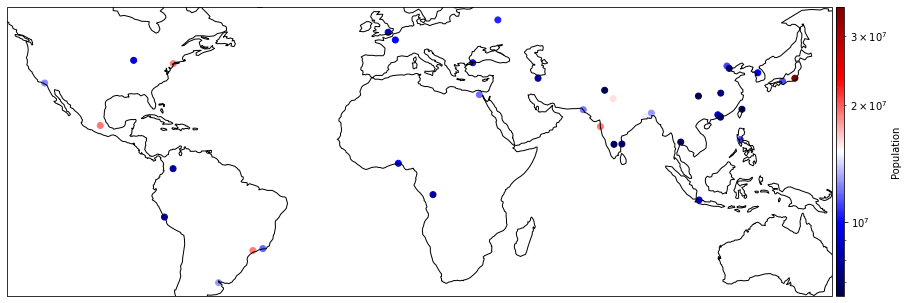

In [38]:
# plot the location of the cities using as basemap the coastlines
from matplotlib.colors import LogNorm
plt.close('all')
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()
img = ax.scatter(pop_gdf.geometry.x, pop_gdf.geometry.y, c=pop_gdf.POP_MAX, cmap=plt.cm.seismic, norm=LogNorm())
cb = colorbar_cartopy(ax, img)
cb.set_label('Population')

In [39]:
# city = pop_gdf.NAME.values.tolist()
lat = pop_gdf.geometry.y.tolist()
lon = pop_gdf.geometry.x.tolist()
coord= [list(z) for z in zip(lat, lon)]

## Scrape weather data from api

Scraping from the "api.weatherbit.io" the content of the field "city_name" in some cases is not obvious to which city it refers. For example, having given the coordinates of New York the "city_name" returned is Little Italy which is in the center of New York. Requestion the timezone it helps to understand to which city belongs corresponding areas as above.

The time difference between most cities means that, in many cases, we have a different day. In order to have a common time reference for all places, we define day 0 as the time we retrieve the data and day 1 as the first day of the weather forecast.  Similarly, for the following days until the day of the event.The results are saved as list named days.

In [45]:
zones = [] # the timezone 
dates = [] # the the local/current date in each city
clouds = [] # average total cloud coverage (%)
cities = [] # names cities or names of areas of the cities
days = [] # the numbered days according to the time at which the data were retrieved
for i,j in coord:
    url ="https://api.weatherbit.io/v2.0/forecast/daily?lat=%s&lon=%s&days=7&key=c6638fc9cac74a3fa1b4a802bb4ce95e"% (i, j)
    # get method of requests module
    # return response object
    response = requests.get(url)
    # json method of response object
    # convert json format data into
    # python format data
    city = response.json()['city_name']
    zone = response.json()['timezone']
    for n in range(7):
        date = response.json()["data"][n]['datetime']
        cloud = response.json()["data"][n]['clouds'] 
        day = f'Day_{n}'
        zones.append(zone)
        cities.append(city)
        dates.append(date)
        clouds.append(cloud)
        days.append(day)

In [41]:
# Convert the lists to dataframes and concatiate them
df1 = pd.DataFrame (cities, columns = ['Area'])
df2 = pd.DataFrame (zones, columns = ['Zone'])
df3 = pd.DataFrame (dates, columns = ['Date'])
df4 = pd.DataFrame (days, columns = ['Days'])
df5 = pd.DataFrame (clouds, columns = ['clouds %'])
df6 = pd.concat([df1, df2,df3,df4,df5], axis=1, ignore_index=True)
df6.columns =['Area','Zone', 'Date','Days', 'Cloud %']

In [42]:
df6.head()

,Area,Zone,Date,Days,Cloud %
0,Tokyo,Asia/Tokyo,2022-10-20,Day_0,4
1,Tokyo,Asia/Tokyo,2022-10-21,Day_1,24
2,Tokyo,Asia/Tokyo,2022-10-22,Day_2,46
3,Tokyo,Asia/Tokyo,2022-10-23,Day_3,34
4,Tokyo,Asia/Tokyo,2022-10-24,Day_4,32


## Process the weather data

Given the weather conditions, we're only concerned with cloud cover. This is given as a percentage from 0 to 100. I then created three categories of cloud cover. From 0 to 33% is the low, from 34% to 66% is the medium  and from 67% to 100% is the high. I saved it as new column in the dataframe names Cloud_range.

In [47]:
df6['Cloud_range'] = np.where(df6['Cloud %']<=33, "low", df6['Cloud %'].values )
df6['Cloud_range'] =np.where(((df6['Cloud %']<=66) & (df6['Cloud %']>33)) , "medium", df6['Cloud_range'].values )
df6['Cloud_range'] =np.where(((df6['Cloud %']<=100) & (df6['Cloud %']>66)) , "high", df6['Cloud_range'].values )

In [48]:
df6.head()

,Area,Zone,Date,Days,Cloud %,Cloud_range
1,Tokyo,Asia/Tokyo,2022-10-21,Day_1,24,low
2,Tokyo,Asia/Tokyo,2022-10-22,Day_2,46,medium
3,Tokyo,Asia/Tokyo,2022-10-23,Day_3,34,medium
4,Tokyo,Asia/Tokyo,2022-10-24,Day_4,32,low
5,Tokyo,Asia/Tokyo,2022-10-25,Day_5,33,low


The above dataframa df6 contains the Day_0, which is the current day, and we don't need it. Moreover, I removed the column Date and the column Zone.

In [49]:
df6 = df6.drop(df6[(df6['Days']== 'Day_0')].index)
#take 4 up to 6 columns
df7 = df6[['Area', 'Days','Cloud %', 'Cloud_range' ]]

In [50]:
df7.head()

,Area,Days,Cloud %,Cloud_range
1,Tokyo,Day_1,24,low
2,Tokyo,Day_2,46,medium
3,Tokyo,Day_3,34,medium
4,Tokyo,Day_4,32,low
5,Tokyo,Day_5,33,low


In [55]:
# encode the column  Cloud_range
from sklearn.preprocessing import LabelEncoder
df7['Cloud_range_enc'] = LabelEncoder().fit_transform(df7['Cloud_range'])
df7.head()
#high=0, low = 1, medium = 2

/tmp/ipykernel_921/2980385280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['Cloud_range_enc'] = LabelEncoder().fit_transform(df7['Cloud_range'])


,Area,Days,Cloud %,Cloud_range,Cloud_range_enc
1,Tokyo,Day_1,24,low,1
2,Tokyo,Day_2,46,medium,2
3,Tokyo,Day_3,34,medium,2
4,Tokyo,Day_4,32,low,1
5,Tokyo,Day_5,33,low,1


In [56]:
# count the frequency of the category "high" (which is equal to 0 in the column Cloud_range_enc) and
# the the frequency of the category "medium" (which is equal to 2 in the column Cloud_range_enc)
# save the results in 2 dataframes
df8=df7.groupby('Area')['Cloud_range_enc'].apply(lambda x: (x==0).sum()).reset_index(name='Count Cloud Cover High')
df9=df7.groupby('Area')['Cloud_range_enc'].apply(lambda x: (x==2).sum()).reset_index(name='Count Cloud Cover Medium')

In [57]:
# merge the 2 dataframes and remove the common column "Area"
df10 = pd.concat([df8,df9], axis=1, ignore_index=False)
df10 = df10.loc[:,~df10.columns.duplicated()].copy()
df10.head()

,Area,Count Cloud Cover High,Count Cloud Cover Medium
0,Beijing,0,0
1,Bengaluru,0,3
2,Bogotá,6,0
3,Buenos Aires,0,3
4,Cairo,0,3


In [58]:
# sort the df7 based on the names of column Area
df7_sorted = df7.sort_values(['Area'],ascending=True)
df7_sorted

,Area,Days,Cloud %,Cloud_range,Cloud_range_enc
109,Beijing,Day_4,0,low,1
107,Beijing,Day_2,0,low,1
106,Beijing,Day_1,17,low,1
110,Beijing,Day_5,0,low,1
111,Beijing,Day_6,19,low,1
...,...,...,...,...,...
233,Youyilu,Day_2,35,medium,2
234,Youyilu,Day_3,31,low,1
235,Youyilu,Day_4,34,medium,2
236,Youyilu,Day_5,60,medium,2


In [59]:
# create a dataframe with 2 columns: "Area" and "Days". In column "Days" each cell contains the days where the cloud cover is high.
out_high = df7_sorted.loc[df7_sorted.Cloud_range == 'high'].groupby(['Area'])['Days'].apply(','.join).reindex((df7_sorted['Area'].drop_duplicates()),fill_value= ' ').reset_index()
# create a dataframe with 2 columns: "Area" and "Days". In column "Days" each cell contains the days where the cloud cover is medium.
out_medium = df7_sorted.loc[df7_sorted.Cloud_range == 'medium'].groupby(['Area'])['Days'].apply(','.join).reindex((df7_sorted['Area'].drop_duplicates()),fill_value= ' ').reset_index()
# create a dataframe with 2 columns: "Area" and "Days". In column "Days" each cell contains the days where the cloud cover is low.
out_low = df7_sorted.loc[df7_sorted.Cloud_range == 'low'].groupby(['Area'])['Days'].apply(','.join).reindex((df7_sorted['Area'].drop_duplicates()),fill_value= ' ').reset_index()

In [61]:
out_high.head()

,Area,Days
0,Beijing,
1,Bengaluru,
2,Bogotá,"Day_6,Day_5,Day_4,Day_3,Day_1,Day_2"
3,Buenos Aires,
4,Cairo,


In [62]:
# create new dataframe merging the df10, out_high, out_low, out_medium, rename the columns and remove duplicates columns
df11 = pd.concat([ df10, out_high, out_low, out_medium], axis=1, ignore_index=True)
df11.columns =[ 'Area','Count_Cloud_Cover_High','Count_Cloud_Cover_Medium', 'Area','Day_Cloud_Cover_High', 'Area','Day_Cloud_Cover_Low','Area', 'Day_Cloud_Cover_Medium']
df11 = df11.loc[:,~df11.columns.duplicated()].copy()
df11.head()

,Area,Count_Cloud_Cover_High,Count_Cloud_Cover_Medium,Day_Cloud_Cover_High,Day_Cloud_Cover_Low,Day_Cloud_Cover_Medium
0,Beijing,0,0,,"Day_4,Day_2,Day_1,Day_5,Day_6,Day_3",
1,Bengaluru,0,3,,"Day_6,Day_4,Day_5","Day_3,Day_2,Day_1"
2,Bogotá,6,0,"Day_6,Day_5,Day_4,Day_3,Day_1,Day_2",,
3,Buenos Aires,0,3,,"Day_4,Day_5,Day_6","Day_1,Day_2,Day_3"
4,Cairo,0,3,,"Day_3,Day_6,Day_2","Day_1,Day_4,Day_5"


In [63]:
#sort the df11 based on those cities that have the least availability
# i.e. based on the two columns: 'Count_Cloud_Cover_High', 'Count_Cloud_Cover_Medium', in desceding order
df11_sorted = df11.sort_values(['Count_Cloud_Cover_High', 'Count_Cloud_Cover_Medium'], ascending=[False, False])
df11_sorted

,Area,Count_Cloud_Cover_High,Count_Cloud_Cover_Medium,Day_Cloud_Cover_High,Day_Cloud_Cover_Low,Day_Cloud_Cover_Medium
2,Bogotá,6,0,"Day_6,Day_5,Day_4,Day_3,Day_1,Day_2",,
13,Jakarta,6,0,"Day_5,Day_3,Day_2,Day_1,Day_4,Day_6",,
18,Lagos,6,0,"Day_2,Day_3,Day_5,Day_1,Day_4,Day_6",,
7,City of Westminster,5,1,"Day_4,Day_2,Day_1,Day_6,Day_5",,Day_3
6,Chongqing,4,2,"Day_5,Day_6,Day_4,Day_3",,"Day_2,Day_1"
15,Kinshasa,4,2,"Day_5,Day_6,Day_1,Day_2",,"Day_4,Day_3"
30,Rio de Janeiro,4,2,"Day_3,Day_4,Day_6,Day_5",,"Day_1,Day_2"
38,Wuhan,4,2,"Day_1,Day_4,Day_5,Day_6",,"Day_3,Day_2"
24,Moscow,3,3,"Day_3,Day_4,Day_2",,"Day_5,Day_6,Day_1"
32,Shanghai,3,3,"Day_2,Day_6,Day_5",,"Day_4,Day_3,Day_1"


Based on the above dataframe df11_sorted, I created two lists "names_cities" and "number_days".
The list "name_cities" contains the names of the cities starting from the city that has the least availability
down to the one that has more days available for image capture.
The list "number_days" contains the corresponding day which a city is availble for image. The corrsponding day
is saved as numbers from 1 to 6. 1 referes to the first day.

In [64]:
names_cities=[]
number_days=[]

for i in range(40):
    for k in range(6):
        if number_days.count(k)>=8: # for each day count the number of cities that have been put and make the appopriate changes
            # if the number reaches the 8. Go the cells of the collumns Day_Cloud_Cover_High and Day_Cloud_Cover_medium and
            # and remove (replace) the day that has reached the number 8 in order to take the other day from the cell.
            df11_sorted['Day_Cloud_Cover_Low']=df11_sorted['Day_Cloud_Cover_Low'].apply(lambda x: x.replace(f"Day_{k}", "")).apply(lambda x: x.strip(","))
            df11_sorted['Day_Cloud_Cover_Low']=df11_sorted['Day_Cloud_Cover_Low'].apply(lambda x: x.replace(",,", ","))
            df11_sorted['Day_Cloud_Cover_Medium'] = df11_sorted['Day_Cloud_Cover_Medium'].apply(lambda x: x.replace(f"Day_{k}", "")).apply(lambda x: x.strip(","))
            df11_sorted['Day_Cloud_Cover_Medium'] = df11_sorted['Day_Cloud_Cover_Medium'].apply(lambda x: x.replace(",,", ","))
    if df11_sorted.iloc[i,4]==" ":
        if df11_sorted.iloc[i,5]==" ":
            print (f'For \033[1m{df11_sorted.iloc[i,0]}\033[0m  there is not availability for the following 6 days')
        else:
            columnindex=min([ int(x) for x in df11_sorted.iloc[i,5].replace("Day_","").split(",") ])
            #print (f'For {df11_sorted.iloc[i,0]} {columnindex}')
            names_cities.append(df11_sorted.iloc[i,0])
            number_days.append(columnindex)
    else:
        columnindex=min([ int(x) for x in df11_sorted.iloc[i,4].replace("Day_","").split(",") ])
        #print (f'For {df11_sorted.iloc[i,0]} {columnindex}')
        names_cities.append(df11_sorted.iloc[i,0])
        number_days.append(columnindex)


For Bogotá  there is not availability for the following 6 days
For Jakarta  there is not availability for the following 6 days
For Lagos  there is not availability for the following 6 days


From the 2 lists "names_cities" and "number_day" I create 6 new lists.
Each list refers to a day and contains the names of the cities that are availble the corresponding day.
I converted the the lists to dataframes and I merged them.

In [65]:
Day_1 =[i for i, n in enumerate(number_days) if n == 1]
Day_2 =[i for i, n in enumerate(number_days) if n == 2]
Day_3 =[i for i, n in enumerate(number_days) if n == 3]
Day_4 =[i for i, n in enumerate(number_days) if n == 4]
Day_5 =[i for i, n in enumerate(number_days) if n == 5]
Day_6 =[i for i, n in enumerate(number_days) if n == 6]

In [28]:
Day_1_list = []
Day_2_list = []
Day_3_list = []
Day_4_list = []
Day_5_list = []
Day_6_list = []
for i in range(len(Day_1)):
    Day_1_list.append(names_cities[Day_1[i]])
for i in range(len(Day_2)):
    Day_2_list.append(names_cities[Day_2[i]])
for i in range(len(Day_3)):
    Day_3_list.append(names_cities[Day_3[i]])
for i in range(len(Day_4)):
    Day_4_list.append(names_cities[Day_4[i]])
for i in range(len(Day_5)):
    Day_5_list.append(names_cities[Day_5[i]])
for i in range(len(Day_6)):
    Day_6_list.append(names_cities[Day_6[i]])

In [29]:
df_Day_1 = pd.DataFrame (Day_1_list, columns = ['First Day'])
df_Day_2 = pd.DataFrame (Day_2_list, columns = ['Second Day'])
df_Day_3 = pd.DataFrame (Day_3_list, columns = ['Third Day'])
df_Day_4 = pd.DataFrame (Day_4_list, columns = ['Fourth Day'])
df_Day_5 = pd.DataFrame (Day_5_list, columns = ['Fifth Day %'])
df_Day_6 = pd.DataFrame (Day_6_list, columns = ['Sixth Day %'])

In [30]:
df_Days_Cities = pd.concat([df_Day_1, df_Day_2,df_Day_3,df_Day_4,df_Day_5, df_Day_6], axis=1, ignore_index=True)
df_Days_Cities.columns =['First Day','Second Day', 'Third Day','Fourth Day', 'Fifth Day', 'Sixth Day']

## Results 

In [31]:
df_Days_Cities # the final dataframe

,First Day,Second Day,Third Day,Fourth Day,Fifth Day,Sixth Day
0,Chongqing,Wuhan,City of Westminster,Tehran,Delhi,Taipei
1,Rio de Janeiro,Paris,Kinshasa,Bengaluru,Guangzhou,NaN
2,Moscow,Cuauhtémoc,George Town,Buenos Aires,Karachi,NaN
3,Shanghai,Manila,Youyilu,Osaka,Lahore,NaN
4,São Paulo,Chicago,Los Angeles,Tokyo,NaN,NaN
5,Kolkata,Kowloon,Seoul,Lima,NaN,NaN
6,Paltan,Pom Prap Sattru Phai,Shenzhen,Mumbai,NaN,NaN
7,Little Italy,Cairo,Eminönü,Beijing,NaN,NaN


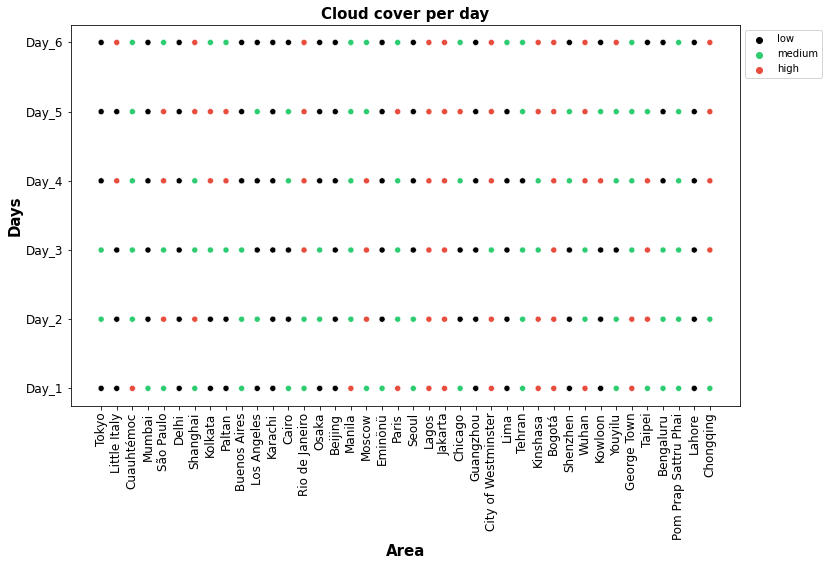

In [75]:
plt.figure(figsize=(12, 7))
sc = sns.scatterplot(x="Area", y="Days", hue='Cloud_range',palette=sns.color_palette(["#000000","#2ecc71","#e74c3c"]), data=df7)
#sns.set(font_scale = 0.6)
sc.tick_params(labelsize=12)
for item in sc.get_xticklabels():
    item.set_rotation(90)
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    m = ax.get_ylabel()
    ax.set_xlabel(l, fontsize=15, weight='bold')
    ax.set_ylabel(m, fontsize=15, weight='bold')
    ax.set_title("Cloud cover per day", fontsize=15, weight='bold')
sc.legend(bbox_to_anchor= (1,1), fontsize='10')
plt.gca().invert_yaxis()

/home/nikkord/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/nikkord/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


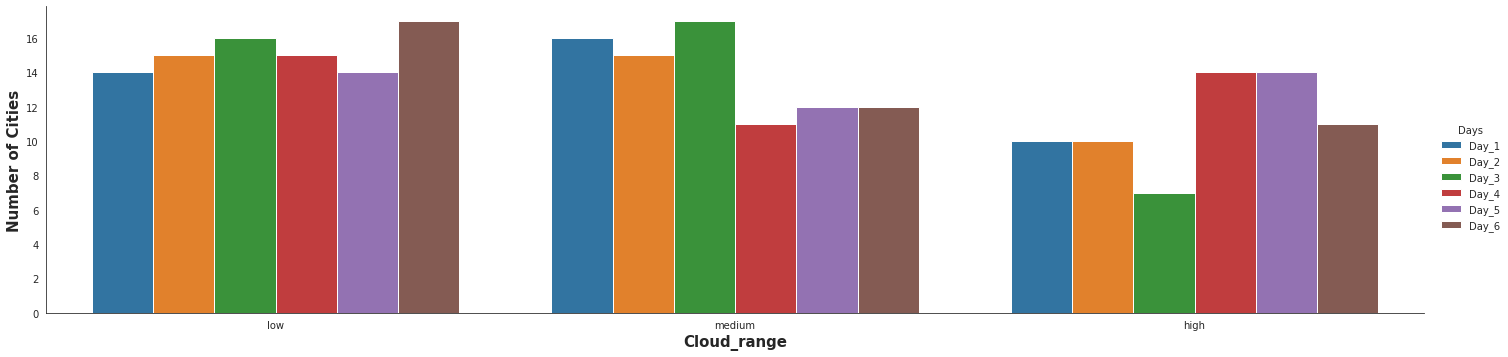

In [54]:
import seaborn as sns
with sns.axes_style('white'):
    g = sns.factorplot("Cloud_range", data=df7, aspect=4.0, kind='count',
                       hue='Days')
    g.set_ylabels('Number of Cities')
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        m = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=15, weight='bold')
        ax.set_ylabel(m, fontsize=15, weight='bold')

In [33]:
df_Days_Cities.to_csv('Availability of 40 Cities.csv')